In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import textwrap
import numpy as np

/home/user/miniconda3/envs/graphing/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "meta-llama/Llama-3.3-70B-Instruct"
bnb_conf = BitsAndBytesConfig(load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_conf,
)
# model.to("cuda")

Loading checkpoint shards:  40%|████      | 12/30 [01:58<02:40,  8.90s/it]

Token: As, Loss: 5.51953125
Token:  we, Loss: 4.86328125
Token:  continue, Loss: 2.578125
Token:  to, Loss: 0.379150390625
Token:  explore, Loss: 2.58984375
Token:  new, Loss: 4.25
Token:  post, Loss: 9.625
Token: -training, Loss: 8.2421875
Token:  techniques, Loss: 3.681640625
Token: ,, Loss: 0.83203125
Token:  today, Loss: 7.46875
Token:  we, Loss: 0.288818359375
Token: 're, Loss: 1.9130859375
Token:  releasing, Loss: 7.9296875
Token: L, Loss: 5.92578125
Token: lama, Loss: 9.5390625
Token:  , Loss: 4.1640625
Token: 3, Loss: 3.876953125
Token: ., Loss: 2.498046875
Token: 3, Loss: 3.45703125
Token: ,, Loss: 5.21484375
Token:  a, Loss: 2.59375
Token:  new, Loss: 2.4375
Token:  open, Loss: 3.044921875
Token:  source, Loss: 3.01953125
Token:  model, Loss: 2.931640625
Token:  that, Loss: 2.986328125
Token:  delivers, Loss: 7.0703125
Token:  leading, Loss: 6.55078125
Token:  performance, Loss: 1.0185546875
Token:  and, Loss: 2.421875
Token:  quality, Loss: 5.1796875
Token: ac, Loss: 10.6718

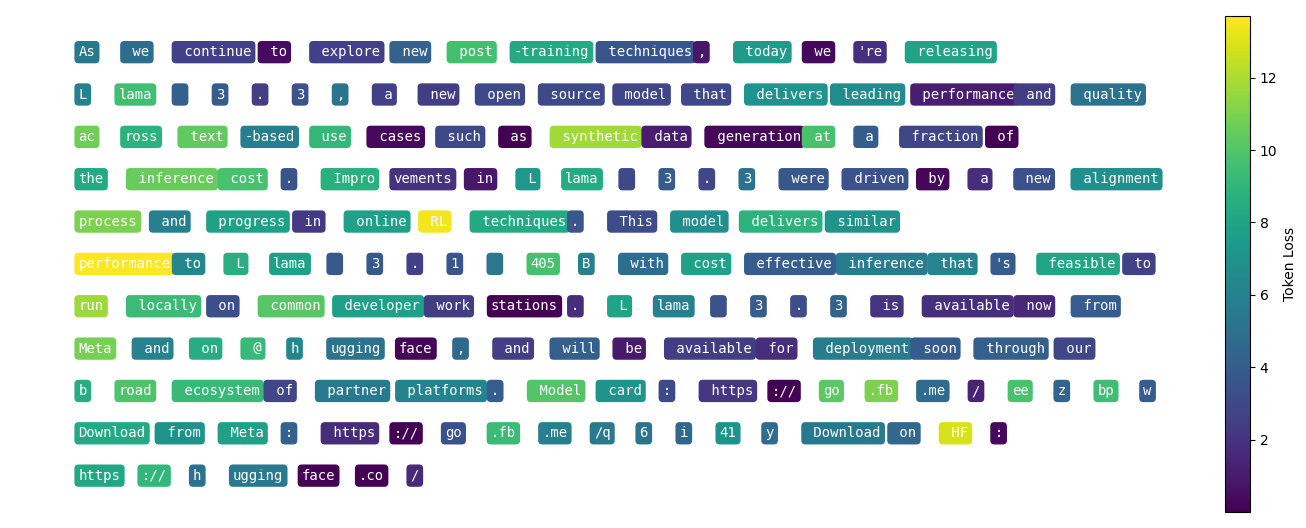

In [40]:
# Define a function to calculate the loss for each token
def calculate_token_loss(inputs):
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    logits = outputs.logits
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = inputs["input_ids"][..., 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss(reduction="none")
    token_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    token_loss = token_loss.view(shift_labels.size())
    return token_loss

# Define a function to visualize the tokens with colors based on their loss
def visualize_token_loss(prompt):
    # Wrap the text into lines of a specified width
    wrapped_lines = textwrap.wrap(prompt, width=80)
    
    token_losses = []
    tokens = []
    
    for line in wrapped_lines:
        inputs = tokenizer(line, return_tensors="pt").to(model.device)
        token_loss = calculate_token_loss(inputs)
        token_losses.extend(token_loss[0].cpu().numpy())
        tokens.extend(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], skip_special_tokens=True))
    
    # Replace 'Ġ' with a space in tokens
    tokens = [token.replace('Ġ', ' ') for token in tokens]
    
    # Print each token with its loss
    for token, loss in zip(tokens, token_losses):
        print(f"Token: {token}, Loss: {loss}")
    
    # Normalize the loss values for coloring
    norm = plt.Normalize(min(token_losses), max(token_losses))
    colors = cm.viridis(norm(token_losses))
    
    # Ensure the lengths match
    colors = colors[:len(tokens)]
    
    # Adjust figure size based on the number of lines
    num_lines = len(wrapped_lines)
    fig_width = 16
    fig_height = num_lines * 0.6  # Adjusted height to reduce spacing between rows
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor='white')
    
    # Plot the tokens with background colors
    y = num_lines - 1
    token_idx = 0
    for line in wrapped_lines:
        inputs = tokenizer(line, return_tensors="pt").to(model.device)
        line_tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0], skip_special_tokens=True)
        line_tokens = [token.replace('Ġ', ' ') for token in line_tokens]
        x = 0
        for token in line_tokens:
            if token_idx < len(colors):
                text = ax.text(x, y, token, fontsize=10, ha='left', va='center', fontfamily='monospace',
                               bbox=dict(facecolor=colors[token_idx], edgecolor='none', boxstyle='round,pad=0.3'), color='white')
                fig.canvas.draw()  # Draw the canvas to get the correct text width
                text_width = text.get_window_extent(renderer=fig.canvas.get_renderer()).width / fig.dpi
                x += text_width + 0.5  # Move x position to the right by the width of the text plus more padding
                token_idx += 1
        y -= 1  # Move to the next line
    
    ax.set_xlim(-1, fig_width)
    ax.set_ylim(-1, num_lines)  # Adjusted ylim to reduce spacing between rows
    ax.axis('off')

    # Add a colorbar legend
    sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Token Loss')
    
    plt.show()

# Display the visualization in the Jupyter Notebook
prompt = """As we continue to explore new post-training techniques, today we're releasing 
Llama 3.3, a new open source model that delivers leading performance 
and quality across text-based use cases such as synthetic data generation at a 
fraction of the inference cost. Improvements in Llama 3.3 were driven by 
a new alignment process and progress in online RL techniques. This model delivers 
similar performance to Llama 3.1 405B with cost effective inference that's 
feasible to run locally on common developer workstations. Llama 3.3 is 
available now from Meta and on @huggingface, and will be available for 
deployment soon through our broad ecosystem of partner platforms.
Model card: https://go.fb.me/eezbpw
Download from Meta: https://go.fb.me/q6i41y
Download on HF: https://huggingface.co/
"""
prompt_full = """As we continue to explore new post-training techniques, today we're releasing Llama 3.3, a new open source model that delivers leading performance and quality across text-based use cases such as synthetic data generation at a fraction of the inference cost. Improvements in Llama 3.3 were driven by a new alignment process and progress in online RL techniques. This model delivers similar performance to Llama 3.1 405B with cost effective inference that's feasible to run locally on common developer workstations. Llama 3.3 is available now from Meta and on @huggingface, and will be available for deployment soon through our broad ecosystem of partner platforms. Model card: https://go.fb.me/eezbpw Download from Meta: https://go.fb.me/q6i41y Download on HF: https://huggingface.co/
"""
visualize_token_loss(prompt_full)

In [46]:
prompt2 = """As we continue to explore new post-training techniques, today we're releasing Llama 3.3, a new open source model that delivers leading performance and quality across text-based use cases such as synthetic data generation at a fraction of the inference cost. Improvements in Llama 3.3 were driven by a new alignment process and progress in online """

inputs = tokenizer(prompt2, return_tensors="pt").to(model.device)

outputs = model.generate(
    **inputs,
    do_sample=False,
    temperature=0.001,
    max_new_tokens=10,
    return_dict_in_generate=True,
    output_scores=True,
    )
# print(outputs)
# scores = outputs.scores

# print(scores)

# tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, normalize_logits=True
)
input_length = inputs.input_ids.shape[1]
generated_tokens = outputs.sequences[:, input_length:]
for tok, score in zip(generated_tokens[0], transition_scores[0]):
    # | token | token string | logits | probability
    score = score.cpu()
    tok = tok.cpu()
    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


|  6975 |  learning | -1.957 | 14.13%
|    11 | ,        | -1.817 | 16.26%
|   902 |  which   | -1.690 | 18.45%
|  6276 |  allows  | -2.060 | 12.74%
|   279 |  the     | -0.688 | 50.28%
|  1646 |  model   | -0.022 | 97.84%
|   311 |  to      | -0.002 | 99.79%
| 10737 |  adapt   | -1.358 | 25.71%
|   311 |  to      | -0.481 | 61.82%
|   502 |  new     | -1.163 | 31.24%


In [48]:
!pip install pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.2 MB/s eta 0:00:00
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)


In [49]:
import pandas as pd

# Extract input_ids and attention_mask from inputs
input_ids = inputs['input_ids'].cpu().numpy()
attention_mask = inputs['attention_mask'].cpu().numpy()

# Create a DataFrame from the input_ids and attention_mask
df_inputs = pd.DataFrame({
    'input_ids': input_ids[0],
    'attention_mask': attention_mask[0]
})

print(df_inputs)

    input_ids  attention_mask
0      128000               1
1        2170               1
2         584               1
3        3136               1
4         311               1
..        ...             ...
67        323               1
68       5208               1
69        304               1
70       2930               1
71        220               1

[72 rows x 2 columns]
